## Семинар 4: "Сверточные сети"

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
import scipy.signal
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.patches as mpatches

### Часть 1: Свертка

#### Одномерные сигналы
Начнем с одномерных сигналов — например, это могут быть различные временные ряды. 

<i>1.1 Реализуйте функцию, вычисляющую одномерную свертку.</i>

In [2]:
def t_convolve(s, k):
    # 1D convolution without padding
    res = np.empty(s.shape[0] - k.shape[0] + 1)
    for i in xrange(s.shape[0] - k.shape[0] + 1):
        i_sum = 0
        for j in xrange(k.shape[0]):
            i_sum += s[i + j] * k[k.shape[0] - j - 1]
        res[i] = i_sum
    return res

In [3]:
s = np.random.randn((5))
k = np.random.randn((2))
print(s, k)
print(t_convolve(s, k))

(array([ 0.10718917, -1.14013699,  1.37152465, -0.58500727, -0.41245655]), array([-1.11305309, -0.94539823]))
[ 1.16769655 -0.44869625 -0.64549283  1.01215087]


Проверим правильность реализации, сравнив с реализацией из scipy

In [4]:
signal = np.random.rand(100)
# kernel = np.random.rand(5)
kernel = np.random.rand(6) # test for even numbers
t_result = t_convolve(signal, kernel)
b_result = scipy.signal.convolve(signal, kernel, mode='valid')

np.testing.assert_allclose(t_result, b_result)

Посмотрим как операция свертки может помочь нам убрать шум из сигнала

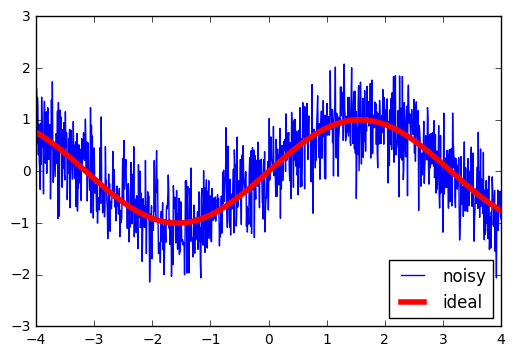

In [5]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(x.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.legend(loc=0)

Для подавления шума можно использовать усреднение значений сигнала в окрестности каждой точки (см. ЗБЧ). Вы можете убедиться, что такая операция может быть реализована при помощи свертки данных с ядром, $[\frac 1w, \frac 1w, ..., \frac 1w]$, где $w$ — размер окна.

<i>1.2  Вычислите свертку сигнала с ядром $[0.2, 0.2, 0.2, 0.2, 0.2]$ </i>

In [6]:
w = 5 # window size
k = np.full((w), float(1) / w)

In [7]:
denoised_signal = t_convolve(noisy_signal, k)

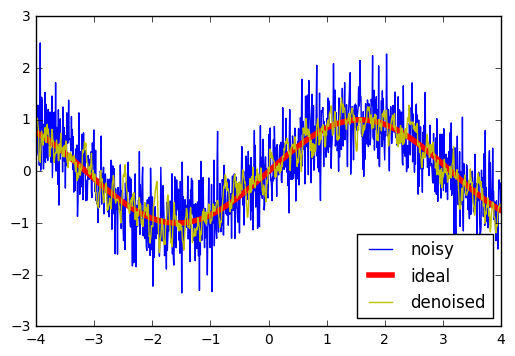

In [8]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(x.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.plot(x[2:-2], denoised_signal, 'y', label='denoised')
plt.legend(loc=0)

Заметим, что уровень шума значительно снизился! Попробуйте подобрать такую ширину окна, чтобы востановленный сигнал был наиболее похож на исходный.

<i> 1.3 Подберите размер окна <i>

In [9]:
minerr = -1 # first pass with a negative value for initialization
bestw = 1
for w in xrange(1, signal.shape[0]):
    k = np.full((w), float(1) / w)
    # de = t_convolve(noisy_signal, k)
    # mse works with equal sizes so I'll take scipy.signal.convolve(..., mode='same')
    de = scipy.signal.convolve(noisy_signal, k, mode = 'same')
    err = mean_squared_error(signal, de)
    if minerr < 0 or err < minerr:
#         print("new best: ", err, ", ", w)
        minerr = err
        bestw = w
print(bestw)

58


#### Многомерные сигналы
Перейдем теперь к черно-белым и цветным изображениям. Для ЧБ изображений имеем двумерный сигнал, для цветных — трехмерный (высота x ширина x каналы).

<i>1.4 Реализуйте функцию, вычисляющую свертку массивов произвольных размерностей.</i>

In [10]:
# i'm too lazy to rectify and simplify this as it turned out to be an optional exercise.
# it only works for odd kernel dimensions and it's a bit bulky

In [11]:
def convolve_at(s, k, s_indices, k_indices = None):
    if k_indices is None:
        k_indices = np.full(k.ndim, -1)
    res = 0 # res as a shared list param? also makes sense
    unfilled = np.where(k_indices == -1)[0]
    if (unfilled.shape[0] == 0): # all indexes determined, fix a point
        new_k_indices = s_indices + k_indices - np.array(k.shape) / 2
        s_val = s[[[ind] for ind in new_k_indices]][0]
        k_val = k[[[ind] for ind in k_indices]][0]
        return s_val * k_val
    else:
        newind = unfilled[0]
        for i in xrange(k.shape[newind]):
            k_indices[newind] = i
            res += convolve_at(s, k, s_indices, k_indices) # recursion
        k_indices[newind] = -1
    return res

In [12]:
def iterate_over(s, k, indices = None, sums = None):
    if indices is None:
        indices = np.full(s.ndim, -1)
    if sums is None:
        sums = np.empty([s.shape[i] - k.shape[i] + 1 for i in xrange(s.ndim)])
    unfilled = np.where(indices == -1)[0]
    if (unfilled.shape[0] == 0): # all indexes determined, fix a point
        sum_indices = indices - np.array(k.shape) / 2
        sums[[[ind] for ind in sum_indices]] = convolve_at(s, k, indices)
    else:
        newind = unfilled[0]
        for i in xrange(k.shape[newind] / 2, s.shape[newind] - (k.shape[newind] / 2)):
            indices[newind] = i
            iterate_over(s, k, indices, sums) # recursion
        indices[newind] = -1
    return sums

In [13]:
def t_convolve_multid(s, k):
    assert s.ndim == k.ndim
    reverse = [slice(None, None, -1)] * k.ndim
    revk = k[reverse]
    
    return iterate_over(s, revk)

In [14]:
signal = np.random.rand(20, 10, 14)
kernel = np.random.rand(9, 3, 5)
t_result = t_convolve_multid(signal, kernel)
b_result = scipy.signal.convolve(signal, kernel, mode='valid')

np.testing.assert_allclose(t_result, b_result)

Для цветных изображений количество каналов ядра обычно совпадает с количеством каналов изображения. Таким образом, в результате получается черно-белое изображение.

<i>1.5 Найдите в вашей любимой поисковой системе коэффициенты каналов для перевода цветного изображения в черно-белое. Постройте фильтр, который будет переводить цветное изображение в ЧБ</i>

In [435]:
# gray = 0.21 * img[:, :, 0] + 0.72 * img[:, :, 1] + 0.07 * img[:, :, 2]

In [15]:
filter = np.array([[[0.21, 0.72, 0.07]]], ndmin=3)

<i>1.6 На примере любого цветного изображения покажите результат его свертки с фильтром из предыдущего задания.</i>

In [16]:
img = plt.imread('test.jpg')
res = scipy.signal.convolve(img, filter, mode = 'valid')
res = np.squeeze(res) # rm trailing dimension

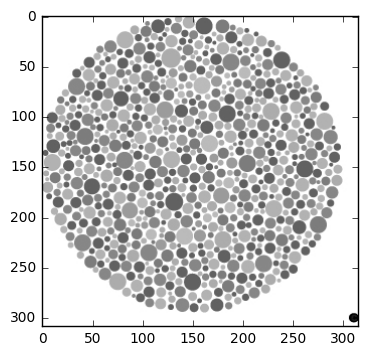

In [17]:
plt.imshow(res, cmap = 'gray')

Операция свертки позволяет находить границы на изображении. Для этого можно использовать, например, фильтр Собеля.

<i>1.7 Задайте ядро фильтра Собеля и продемонстрируйте результат его применения к любому цветному изображению.</i>

In [18]:
sobel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]]) # horizontal kernel
sobelrgb = np.array([sobel] * 3)

In [19]:
img = plt.imread('test.jpg')
res = np.empty_like(img)

In [20]:
for i in xrange(img.shape[2]):
    res[:, :, i] = scipy.signal.convolve(img[:, :, i], sobelrgb[:, :, i], mode = 'same') # apply sobel to each channel
meanres = res.mean(axis = 2) # and then average it
plt.imsave('mean.jpg', meanres, cmap = 'gray')

В сверточных нейронных сетях каждый слой использует несколько фильтров. Допустим, у нас было изображение с тремя каналами (количество входных каналов). Рассмотрим банк из четырех фильтров (количество выходных каналов). Тогда изначально будет вычислена свертка с каждым фильтром — получим 4 ЧБ изображения. Теперь соединим их в одно, интерпретируя каждое ЧБ изображение как канал цветного: RGB$\alpha$.

<i>1.8 Реализуйте операцию свертки с банком фильтров (filter bank).</i>

In [21]:
def t_convolve_bank(signal, kernels):
    res = np.empty(list(img.shape)[:-1] + [kernels.shape[0]])
    assert signal.ndim == kernels.ndim - 1
    for j in xrange(kernels.shape[0]):
#         for i in xrange(signal.shape[2]):
#         cur = scipy.signal.convolve(signal[:, :, i], kernels[j, :, :, i], mode = 'same')
        cur = scipy.signal.convolve(signal, kernels[j, :, :, :], mode = 'valid')[:, :, 0]
        res[:, :, j] = cur
    return res

<i>1.9 Задайте банк фильтров, меняющий порядок следования каналов с RGB на BGR.</i>

In [22]:
red = np.array([0, 0, 1])[np.newaxis, np.newaxis]
green = np.array([0, 1, 0])[np.newaxis, np.newaxis]
blue = np.array([1, 0, 0])[np.newaxis, np.newaxis]
fil = np.array([blue, green, red])

<i>1.10 Продемонстрируйте результат свертки любого цветного изображения с банком фильтров из предыдущего пункта.</i>

In [23]:
img = plt.imread('test.jpg')

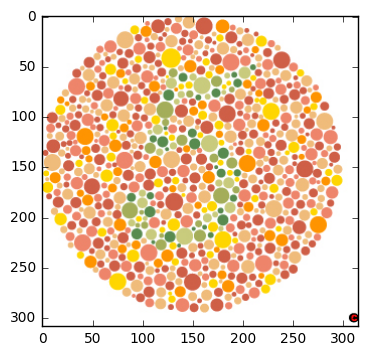

In [24]:
plt.imshow(img)

In [25]:
img2 = t_convolve_bank(img, fil).astype('uint8')

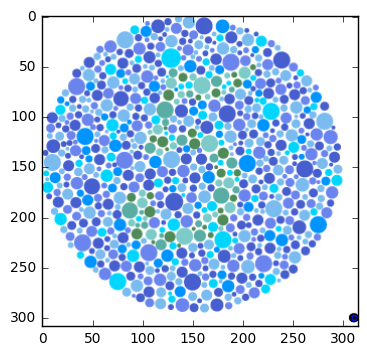

In [26]:
plt.imshow(img2)

В процессе обучения сверточных нейронных сетей настраиваются веса элементов фильтр банка. Это позволяет не заниматься подбором коэффициентов "руками", а задавать лишь размер ядра: ширину, высоту, количество входных и выходных каналов. В итоге получаем четырехмерный массив (тензор).

### Часть 2: Пулинг

При использовании сверточных слоев принято использовать слои пулинга. Эта операция позволяет уменьшить пространственные размерности изображения и избавиться от избыточности.

<i>2.1 Реализуйте операции пулинга для цветных изображений</i>

In [27]:
def maxpool(img):
    assert(img.ndim == 3)
    out = np.empty((int(np.ceil(float(img.shape[0]) / 2)), int(np.ceil(float(img.shape[1]) / 2)), img.shape[2]))
    for c in xrange(out.shape[2]):
        for i in xrange(out.shape[0]):
            for j in xrange(out.shape[1]): #iterate over channels
                vals = img[i * 2:(i + 1) * 2, j * 2:(j + 1) * 2, :].reshape(-1, out.shape[2])
                out[i, j, :] = vals.max(axis = 0)
    return out.astype('uint8')

def medianpool(image):
    assert(image.ndim == 3)
    out = np.empty((int(np.ceil(float(img.shape[0]) / 2)), int(np.ceil(float(img.shape[1]) / 2)), img.shape[2]))
    for c in xrange(out.shape[2]):
        for i in xrange(out.shape[0]):
            for j in xrange(out.shape[1]): #iterate over channels
                vals = img[i * 2:(i + 1) * 2, j * 2:(j + 1) * 2, :].reshape(-1, out.shape[2])
                out[i, j, :] = np.median(vals, axis = 0)
    return out.astype('uint8')

Как и в первой части, посмотрим сначала как эта опреация влияет на цветные изображения.

<i>2.2 Взять цветное изображение и добавить к нему <a href="https://ru.wikipedia.org/wiki/Salt_and_pepper"> шум соль и перец</a>. Применить медианный пулинг и максимальный пулинг.</i>

In [28]:
img = plt.imread('test.jpg')

In [29]:
def sap(img, points_n, color):
    xdots = np.random.randint(0, img.shape[0], size = points_n)
    ydots = np.random.randint(0, img.shape[1], size = points_n)
    for i in xrange(points_n):
        for j in xrange(img.shape[2]):
            img[xdots[i], ydots[i], j] = color

In [30]:
sap(img, 1200, 0)

In [31]:
sap(img, 1200, 255)

In [32]:
maximg = maxpool(img)
medianimg = medianpool(img)

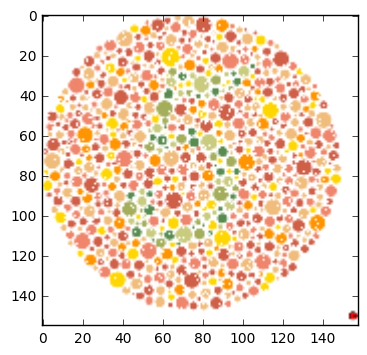

In [33]:
plt.imshow(maximg)

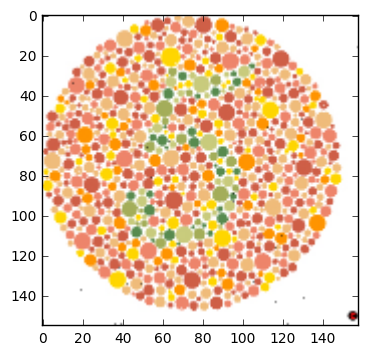

In [34]:
plt.imshow(medianimg)

### Часть 3: Сверточная сеть на pyTorch

pyTorch предоставляет модули свертки и пулинга. Попробуем построить сеть и натренировать ее на данных MNIST

In [35]:
mnist = fetch_mldata('MNIST original', data_home='~/.datasets')
images = mnist['data']
images = images.reshape(images.shape[0], 1, 28, 28) # data dims: examples x channels x w x h
images = images.astype(np.float32) / 255 # float and normalize
labels = mnist['target'].astype(int)
np_images_train, np_images_test, np_labels_train, np_labels_test = train_test_split(images, labels)

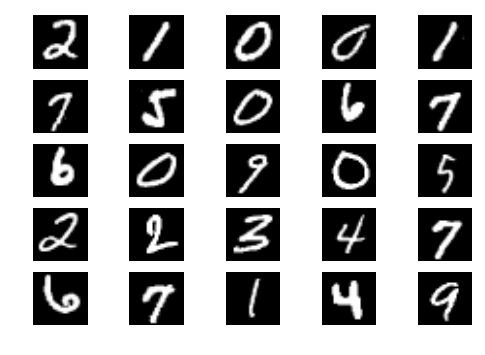

In [36]:
for i in xrange(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(np_images_train[i, 0, :, :], cmap='gray')
    plt.axis('off')

Воспользуемся кодом с предыдущего семинара, чтобы обучить сверточную сеть на данных MNIST. Попробуем две архитектуры: 
2. input -> 8 conv 3x3 -> ReLU -> maxpool -> 16 conv 3x3 -> ReLU -> ravel -> linear -> softmax
1. input -> 8 conv 3x3 -> ReLU -> 16 conv 3x3 -> ReLU -> maxpool -> 32 conv 3x3 -> ravel -> linear -> softmax

* nn.functional.conv2d
* nn.MaxPool2d
* nn.Reshape (чтобы перевести изображения в вектор)

In [53]:
class myConvNet(nn.Module):
    def __init__(self, size):
        super(myConvNet, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 8, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
                                         nn.Conv2d(8, 16, 3, padding=1), nn.ReLU())
        self.linear_layers = nn.Sequential(nn.Linear(size/2 * size/2 * 16, 10),
                                           nn.LogSoftmax())
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [54]:
class myConvNet2(nn.Module):
    def __init__(self, size):
        super(myConvNet2, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 8, 3, padding=1), nn.ReLU(), 
                                         nn.Conv2d(8, 16, 3, padding = 1), nn.ReLU(), nn.MaxPool2d(2),
                                         nn.Conv2d(16, 32, 3, padding = 1))
        self.linear_layers = nn.Sequential(nn.Linear(size/2 * size/2 * 32, 10),
                                           nn.LogSoftmax())
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [55]:
from tqdm import tqdm

In [56]:
def learn(network, epochs, np_images_train, np_labels_train, np_images_test, np_labels_test):
    lossf = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
    batchsize = 32
    iters = int(np.ceil(float(np_images_train.shape[0]) / batchsize))
#     iters = 100
    losses = np.zeros((epochs * iters, 2))

    for ep in xrange(epochs):
        p = np.random.permutation(len(np_labels_train))
        np_images_train = np_images_train[p, :]
        np_labels_train = np_labels_train[p]

        images_train = torch.from_numpy(np_images_train).type(torch.FloatTensor)
        labels_train = torch.from_numpy(np_labels_train)
        images_test = torch.from_numpy(np_images_test).type(torch.FloatTensor)
        labels_test = torch.from_numpy(np_labels_test)

        for i in tqdm(xrange(iters)):
#         for i in xrange(iters):
            # train
            X = Variable(images_train[i * batchsize:(i + 1) * batchsize])
            y = Variable(labels_train[i * batchsize:(i + 1) * batchsize], requires_grad=False)
            output = network.forward(X)
            
            loss = lossf(output, y)
            losses[ep * iters + i, 0] = loss.data.numpy()[0]
            
            # test
            p = np.random.randint(len(np_labels_test), size = batchsize)
            cur_images = np_images_test[p, :]
            cur_labels = np_labels_test[p]

            test_x = Variable(torch.from_numpy(cur_images))
            test_y = Variable(torch.from_numpy(cur_labels))

            test_y_pred = network.forward(test_x)
            test_loss = lossf(test_y_pred, test_y)
            losses[ep * iters + i, 1] = test_loss.data.numpy()[0]
            
            # back
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return losses

In [57]:
def plot(data, xlabel, ylabel, label1, label2):
    plt.figure(1, figsize = (6, 3))
    c1 = np.random.random_sample((3,))
    c2 = np.random.random_sample((3,))
    plt.plot(xrange(data.shape[0]), data[:, 0], color = c1, alpha = 0.8)
    plt.plot(xrange(data.shape[0]), data[:, 1], color = c2, alpha = 0.8)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    patch1 = mpatches.Patch(color=c1, label=label1)
    patch2 = mpatches.Patch(color=c2, label=label2)
    plt.legend(handles=[patch1, patch2])

100%|██████████| 1641/1641 [00:30<00:00, 54.19it/s]


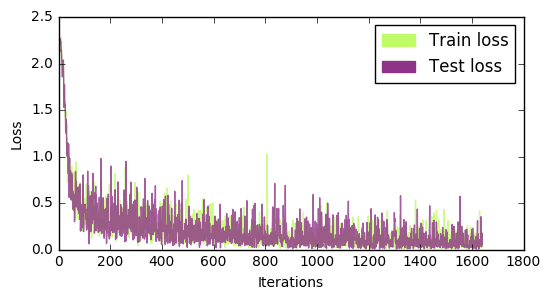

In [58]:
losses = learn(myConvNet(np_images_train.shape[2]), 1, np_images_train, np_labels_train, np_images_test, np_labels_test)
plot(losses, 'Iterations', 'Loss', 'Train loss', 'Test loss')

100%|██████████| 1641/1641 [01:15<00:00, 26.35it/s]


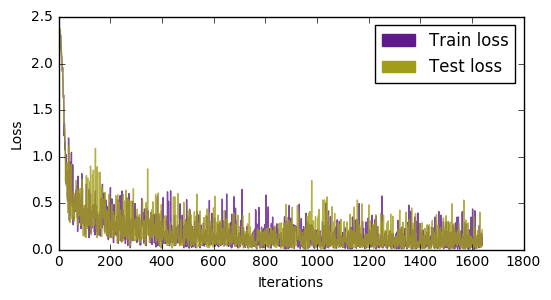

In [59]:
losses = learn(myConvNet2(np_images_train.shape[2]), 1, np_images_train, np_labels_train, np_images_test, np_labels_test)
plot(losses, 'Iterations', 'Loss', 'Train loss', 'Test loss')

<i>3.1 Обучите сверточные сети с архитектурами (1) и (2). Какое качество удалось получить на тестовой выборке? Какой результат получался на полносвязной нейронной сети?</i>

На полносвязной NLLLoss снижался до 0.4 - 0.5, здесь на тестовой выборке получается в среднем в районе 0.1
Судя по графикам, сеть с третьим сверточным слоем обучилась немного лучше, но и здесь кое-где попадаются пики выше 0.5

<i>3.2 На каких объектах сеть ошибается сильнее всего?</i>

На тех же, на которых человек ошибается чаще всего - которые похожи на объекты и одного, и другого класса

<i>3.3 Поэкспериментируйте с различными архитектурами сверточных сетей. Смогли ли вы улучшить результат на тестовой выборке?</i>

In [60]:
class myConvNet3(nn.Module):
    def __init__(self, size):
        super(myConvNet3, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 8, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
                                         nn.Conv2d(8, 16, 3, padding = 1), nn.ReLU(), nn.MaxPool2d(2),
                                         nn.Conv2d(16, 32, 3, padding = 1), nn.ReLU(), nn.MaxPool2d(2),
                                         nn.Conv2d(32, 32, 3, padding = 1), nn.ReLU())
        res_size = int(float(size / 8))
        self.linear_layers = nn.Sequential(nn.Linear(res_size * res_size *32, 10),
                                           nn.LogSoftmax())
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

100%|██████████| 1641/1641 [00:37<00:00, 43.34it/s]


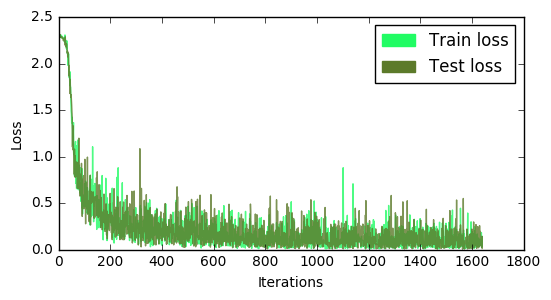

In [61]:
losses = learn(myConvNet3(np_images_train.shape[2]), 1, np_images_train, np_labels_train, np_images_test, np_labels_test)
plot(losses, 'Iterations', 'Loss', 'Train loss', 'Test loss')

In [ ]:
# fits even better but the improvement is slight